<a href="https://colab.research.google.com/github/Vijayalakshmi2608/UIDAI_Early_Warning_System/blob/main/UIDAI_Early_Warning_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

OUTPUT_DIR = "/content/UIDAI_Project_Outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Output directory ready:", OUTPUT_DIR)


Output directory ready: /content/UIDAI_Project_Outputs


In [ ]:
!pip install pandas numpy matplotlib seaborn scipy statsmodels pyod


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 10.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from scipy import stats
import statsmodels.api as sm
from pyod.models.iforest import IForest

sns.set_style("whitegrid")


In [ ]:
import zipfile

with zipfile.ZipFile("/content/api_data_aadhar_enrolment.zip") as z:
    print(z.namelist())



['api_data_aadhar_enrolment/', 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_0_500000.csv', 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_1000000_1006029.csv', 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_500000_1000000.csv']


In [ ]:
with zipfile.ZipFile("/content/api_data_aadhar_demographic.zip") as z:
    print(z.namelist())


['api_data_aadhar_demographic/', 'api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv', 'api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv', 'api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv', 'api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv', 'api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv']


In [ ]:
with zipfile.ZipFile("/content/api_data_aadhar_biometric.zip") as z:
    print(z.namelist())


['api_data_aadhar_biometric/', 'api_data_aadhar_biometric/api_data_aadhar_biometric_0_500000.csv', 'api_data_aadhar_biometric/api_data_aadhar_biometric_1000000_1500000.csv', 'api_data_aadhar_biometric/api_data_aadhar_biometric_1500000_1861108.csv', 'api_data_aadhar_biometric/api_data_aadhar_biometric_500000_1000000.csv']


In [ ]:
import zipfile
import pandas as pd

def load_multi_csv_zip(zip_path):
    with zipfile.ZipFile(zip_path) as z:
        csv_files = [f for f in z.namelist() if f.endswith(".csv")]
        df_list = []
        for file in csv_files:
            df_list.append(pd.read_csv(z.open(file)))
        return pd.concat(df_list, ignore_index=True)

demo = load_multi_csv_zip("/content/api_data_aadhar_demographic.zip")
print(demo.shape)



(2071700, 6)


In [ ]:
bio = load_multi_csv_zip("/content/api_data_aadhar_biometric.zip")
print(bio.shape)


(1861108, 6)


In [ ]:
enrol = load_multi_csv_zip("/content/api_data_aadhar_enrolment.zip")

print("Enrolment:", enrol.shape)
print("Demographic:", demo.shape)
print("Biometric:", bio.shape)


Enrolment: (1006029, 7)
Demographic: (2071700, 6)
Biometric: (1861108, 6)


In [ ]:
for df in [enrol, demo, bio]:
    df.columns = df.columns.str.strip().str.lower()


In [ ]:
for name, df in zip(["Enrolment", "Demographic", "Biometric"], [enrol, demo, bio]):
    print(f"\n{name}")
    display(df.info())
    display(df.isnull().sum())



Enrolment
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006029 entries, 0 to 1006028
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   date            1006029 non-null  object
 1   state           1006029 non-null  object
 2   district        1006029 non-null  object
 3   pincode         1006029 non-null  int64 
 4   age_0_5         1006029 non-null  int64 
 5   age_5_17        1006029 non-null  int64 
 6   age_18_greater  1006029 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 53.7+ MB


None

,0
date,0
state,0
district,0
pincode,0
age_0_5,0
age_5_17,0
age_18_greater,0



Demographic
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071700 entries, 0 to 2071699
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   date           object
 1   state          object
 2   district       object
 3   pincode        int64 
 4   demo_age_5_17  int64 
 5   demo_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 94.8+ MB


None

,0
date,0
state,0
district,0
pincode,0
demo_age_5_17,0
demo_age_17_,0



Biometric
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861108 entries, 0 to 1861107
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   date          object
 1   state         object
 2   district      object
 3   pincode       int64 
 4   bio_age_5_17  int64 
 5   bio_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 85.2+ MB


None

,0
date,0
state,0
district,0
pincode,0
bio_age_5_17,0
bio_age_17_,0


In [ ]:
for df in [enrol, demo, bio]:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [ ]:
for df in [enrol, demo, bio]:
    print(df['date'].min(), df['date'].max())


2025-01-04 00:00:00 2025-12-11 00:00:00
2025-01-03 00:00:00 2025-12-12 00:00:00
2025-01-03 00:00:00 2025-12-12 00:00:00


In [ ]:
for df in [enrol, demo, bio]:
    df['state'] = df['state'].str.strip().str.title()
    df['district'] = df['district'].str.strip().str.title()


In [ ]:
for df in [enrol, demo, bio]:
    df['month'] = df['date'].dt.to_period('M')


In [ ]:
merged['service_stress_index'] = (
    merged['demo_updates'] + merged['bio_updates']
) / (merged['enrolments'] + 1)


In [ ]:
risk_regions = merged.groupby('state')['service_stress_index'].mean().sort_values(ascending=False)
risk_regions.head(10)


,service_stress_index
state,
Kerala,12.584373
Andaman & Nicobar Islands,11.005357
Andhra Pradesh,10.942154
Himachal Pradesh,10.536912
Daman And Diu,10.529861
Andaman And Nicobar Islands,10.046086
Lakshadweep,9.037500
Ladakh,9.029966
Daman & Diu,9.000000


In [ ]:
import numpy as np

def compute_trend(series):
    series = series.dropna()

    # Minimum data points required
    if len(series) < 3:
        return 0.0

    # If no variation, no trend
    if series.nunique() == 1:
        return 0.0

    x = np.arange(len(series))
    y = series.values

    try:
        slope = np.polyfit(x, y, 1)[0]
        return slope
    except:
        return 0.0


In [ ]:
merged['stress_trend'] = (
    merged
    .sort_values('month')
    .groupby(['state','district'])['service_stress_index']
    .transform(compute_trend)
)


In [ ]:
merged['stress_trend'].describe()


,stress_trend
count,11953.000000
mean,-0.248862
std,0.435437
min,-8.500000
25%,-0.325871
50%,-0.226333
75%,-0.124709
max,8.928571


In [ ]:
emerging_risk = (
    merged.groupby(['state','district'])['stress_trend']
    .mean()
    .sort_values(ascending=False)
)

emerging_risk.head(10)


state        district          
Maharashtra  Ahilyanagar           8.928571
             Gondiya *             1.537529
Punjab       Nawanshahr            1.451815
Bihar        Pashchim Champaran    1.170746
Rajasthan    Didwana-Kuchaman      0.930070
Gujarat      Panch Mahals          0.752115
Maharashtra  Washim *              0.720280
Orissa       Ganjam                0.702763
Maharashtra  Hingoli *             0.700000
Karnataka    Bengaluru South       0.670122
Name: stress_trend, dtype: float64

In [ ]:
final_table = (
    merged
    .groupby(['state','district'])
    .agg(
        avg_enrolments = ('enrolments','mean'),
        avg_demo_updates = ('demo_updates','mean'),
        avg_bio_updates = ('bio_updates','mean'),
        avg_stress = ('service_stress_index','mean'),
        stress_trend = ('stress_trend','mean')
    )
    .reset_index()
)


In [ ]:
final_table['risk_level'] = pd.cut(
    final_table['avg_stress'],
    bins=[-1, 0.5, 1.0, 2.0, 100],
    labels=['Low','Moderate','High','Critical']
)


<Axes: xlabel='month'>

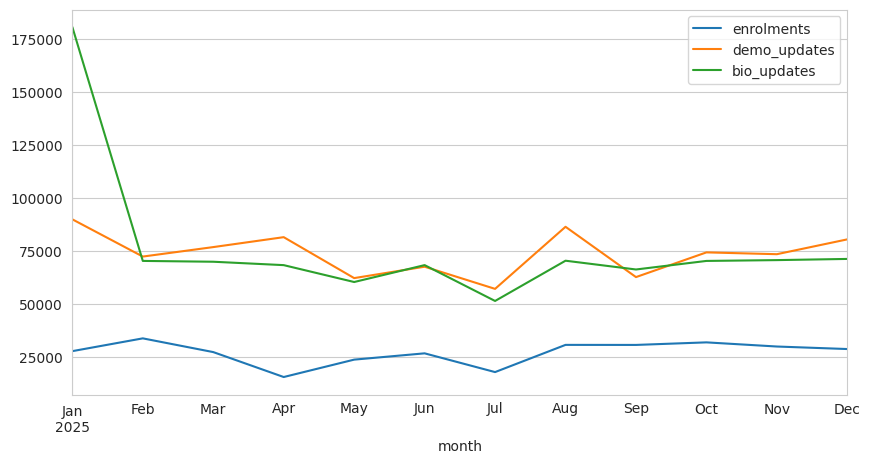

In [ ]:
national = merged.groupby('month')[['enrolments','demo_updates','bio_updates']].sum()

national.plot(figsize=(10,5))


<Axes: ylabel='Frequency'>

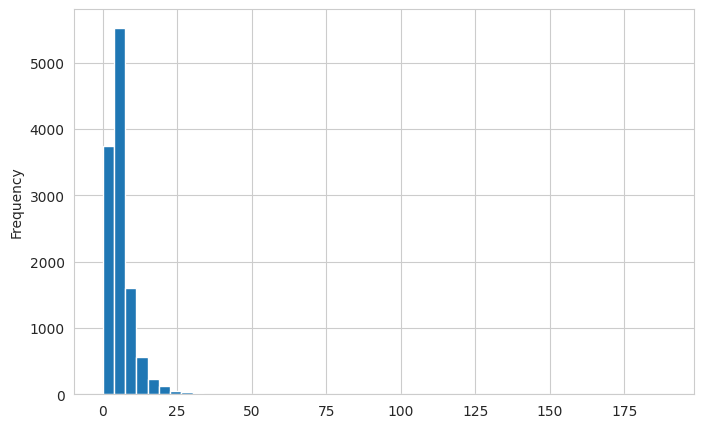

In [ ]:
merged['service_stress_index'].plot(kind='hist', bins=50, figsize=(8,5))


<Axes: xlabel='state'>

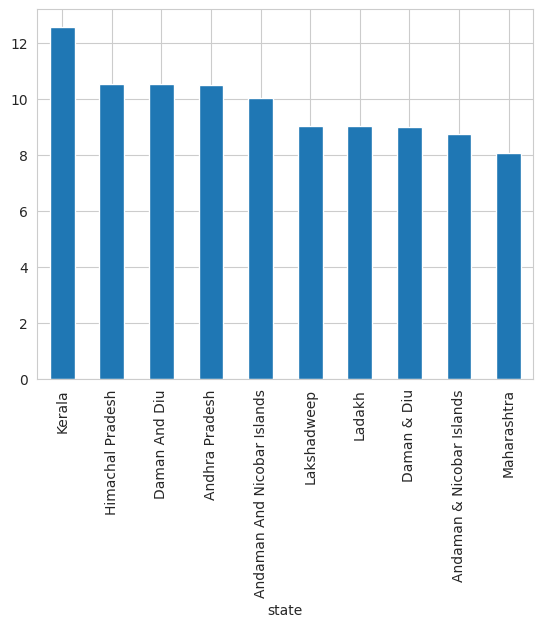

In [ ]:
final_table.groupby('state')['avg_stress'].mean().sort_values(ascending=False).head(10).plot(kind='bar')


In [ ]:
final_table.sort_values('stress_trend', ascending=False).head(10)[['state','district','stress_trend']]


,state,district,stress_trend
524,Maharashtra,Ahilyanagar,8.928571
544,Maharashtra,Gondiya *,1.537529
738,Punjab,Nawanshahr,1.451815
145,Bihar,Pashchim Champaran,1.170746
767,Rajasthan,Didwana-Kuchaman,0.930070
261,Gujarat,Panch Mahals,0.752115
575,Maharashtra,Washim *,0.720280
686,Orissa,Ganjam,0.702763
546,Maharashtra,Hingoli *,0.700000
400,Karnataka,Bengaluru South,0.670122


<Axes: xlabel='avg_enrolments', ylabel='avg_demo_updates'>

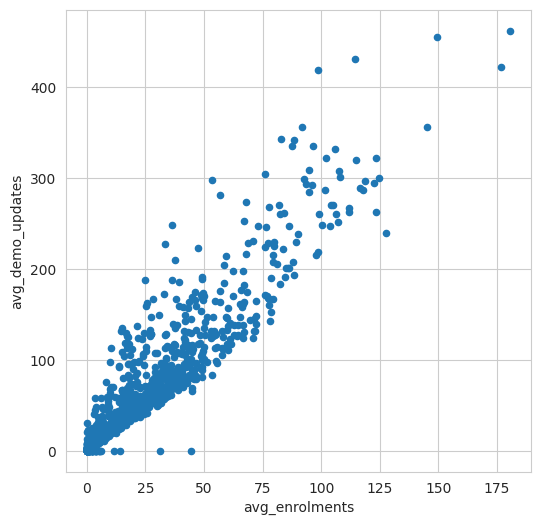

In [ ]:
final_table.plot.scatter(x='avg_enrolments', y='avg_demo_updates', figsize=(6,6))


In [ ]:
from scipy.stats import pearsonr

r, p = pearsonr(
    final_table['avg_enrolments'],
    final_table['avg_demo_updates']
)

r, p


(np.float64(0.926671852986054), np.float64(0.0))

In [ ]:
final_table.sort_values(
    ['risk_level','stress_trend'],
    ascending=[False, False]
).head(20)


,state,district,avg_enrolments,avg_demo_updates,avg_bio_updates,avg_stress,stress_trend,risk_level
524,Maharashtra,Ahilyanagar,0.000000,30.142857,0.142857,30.285714,8.928571,Critical
544,Maharashtra,Gondiya *,1.416667,18.166667,19.833333,21.677778,1.537529,Critical
738,Punjab,Nawanshahr,3.750000,47.583333,54.833333,33.611111,1.451815,Critical
145,Bihar,Pashchim Champaran,3.333333,15.750000,7.750000,9.489394,1.170746,Critical
767,Rajasthan,Didwana-Kuchaman,0.000000,12.583333,0.083333,12.666667,0.930070,Critical
261,Gujarat,Panch Mahals,2.166667,9.750000,8.083333,7.118651,0.752115,Critical
575,Maharashtra,Washim *,0.500000,11.750000,14.583333,19.388889,0.720280,Critical
686,Orissa,Ganjam,9.916667,63.083333,56.250000,13.286156,0.702763,Critical
400,Karnataka,Bengaluru South,2.833333,40.000000,5.166667,15.027579,0.670122,Critical
154,Bihar,Samstipur,2.250000,12.833333,7.916667,9.452976,0.605986,Critical


In [ ]:
final_table.to_csv("uidai_early_warning_output.csv", index=False)


In [ ]:
final_table['update_pressure'] = (
    final_table['avg_demo_updates'] + final_table['avg_bio_updates']
) / (final_table['avg_enrolments'] + 1)


<Axes: xlabel='avg_enrolments', ylabel='update_pressure'>

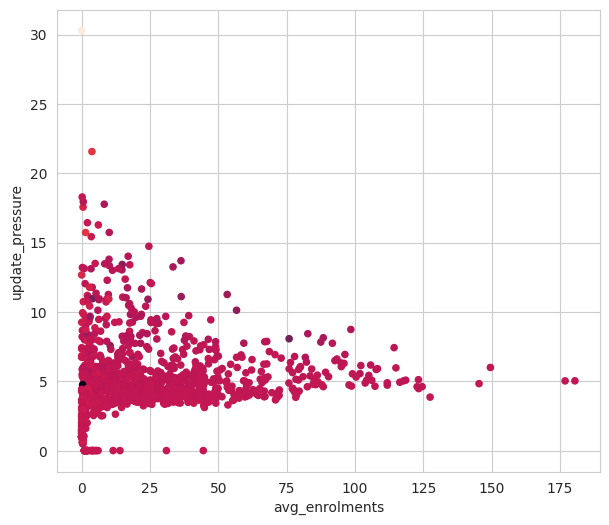

In [ ]:
final_table.plot.scatter(
    x='avg_enrolments',
    y='update_pressure',
    c=final_table['stress_trend'],
    figsize=(7,6)
)


<Axes: xlabel='quarter'>

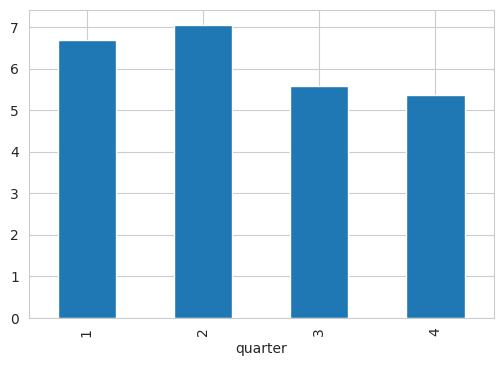

In [ ]:
merged['quarter'] = merged['month'].dt.quarter

seasonal = merged.groupby('quarter')['service_stress_index'].mean()
seasonal.plot(kind='bar', figsize=(6,4))


In [ ]:
import numpy as np
from scipy.stats import zscore

def safe_zscore(series):
    series = series.dropna()

    if len(series) < 3:
        return pd.Series([0]*len(series), index=series.index)

    if series.std() == 0:
        return pd.Series([0]*len(series), index=series.index)

    z = zscore(series)
    return pd.Series(z, index=series.index)


In [ ]:
merged['stress_z'] = (
    merged
    .sort_values('month')
    .groupby(['state','district'])['service_stress_index']
    .apply(safe_zscore)
    .reset_index(level=[0,1], drop=True)
)


In [ ]:
anomalies = merged[merged['stress_z'].abs() > 3]

anomalies[['state','district','month','service_stress_index','stress_z']].head(10)


,state,district,month,service_stress_index,stress_z
142,Andhra Pradesh,Annamayya,2025-01,35.000000,3.047722
214,Andhra Pradesh,Eluru,2025-01,68.400000,3.062935
506,Andhra Pradesh,Sri Potti Sriramulu Nellore,2025-04,21.000000,3.005923
842,Arunachal Pradesh,Tawang,2025-04,21.000000,3.068360
1142,Assam,Kamrup Metro,2025-04,10.434783,3.095606
1190,Assam,Lakhimpur,2025-04,8.642857,3.055142
1716,Bihar,Purba Champaran,2025-02,38.000000,3.062893
1852,Bihar,Sitamarhi,2025-04,6.692308,3.151533
1900,Bihar,West Champaran,2025-04,6.227273,3.005249
1938,Chhattisgarh,Balod,2025-01,14.200000,3.034552


In [ ]:
def iqr_anomaly(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        return pd.Series([False]*len(series), index=series.index)
    return (series < q1 - 3*iqr) | (series > q3 + 3*iqr)

merged['iqr_anomaly'] = (
    merged
    .groupby(['state','district'])['service_stress_index']
    .transform(iqr_anomaly)
)


<Axes: xlabel='month'>

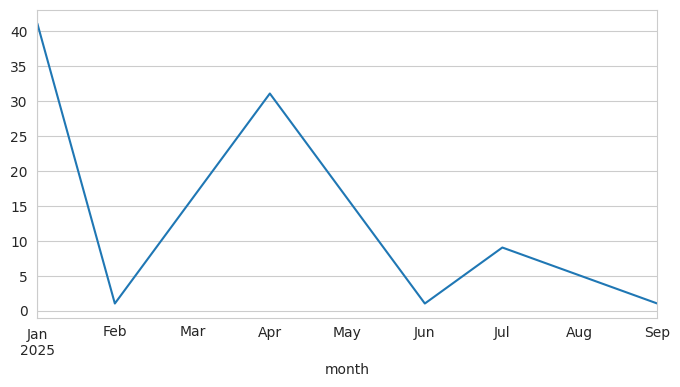

In [ ]:
anomalies.groupby('month').size().plot(figsize=(8,4))


In [ ]:
final_table['capacity_gap'] = (
    final_table['avg_demo_updates'] + final_table['avg_bio_updates']
) - final_table['avg_enrolments']

In [ ]:
final_table.sort_values('capacity_gap', ascending=False).head(10)[
    ['state','district','capacity_gap']
]

,state,district,capacity_gap
458,Kerala,Thrissur,770.500000
1018,West Bengal,Barddhaman,753.083333
18,Andhra Pradesh,East Godavari,741.666667
1049,West Bengal,North 24 Parganas,732.333333
563,Maharashtra,Pune,717.166667
455,Kerala,Palakkad,639.250000
52,Andhra Pradesh,West Godavari,625.916667
446,Kerala,Ernakulam,623.000000
457,Kerala,Thiruvananthapuram,605.083333
28,Andhra Pradesh,Krishna,578.333333


In [ ]:
final_table['stress_after_intervention'] = (
    final_table['avg_demo_updates'] + final_table['avg_bio_updates']
) / (final_table['avg_enrolments'] * 1.2 + 1)


In [ ]:
final_table['stress_after_intervention'] = (
    final_table['avg_demo_updates'] + final_table['avg_bio_updates']
) / (final_table['avg_enrolments'] * 1.2 + 1)


In [ ]:
final_table['stress_reduction_pct'] = (
    (final_table['avg_stress'] - final_table['stress_after_intervention'])
    / final_table['avg_stress']
) * 100


In [ ]:
final_table['stress_reduction_pct'].describe()


,stress_reduction_pct
count,1038.000000
mean,20.978053
std,8.180342
min,-0.648113
25%,18.588570
50%,20.719079
75%,23.818381
max,71.046001


In [ ]:
policy_targets = (
    final_table[final_table['risk_level'].isin(['High','Critical'])]
    .sort_values('stress_reduction_pct', ascending=False)
    .head(15)
)

policy_targets[['state','district','stress_reduction_pct']]


,state,district,stress_reduction_pct
451,Kerala,Kollam,71.046001
240,Gujarat,Banas Kantha,59.223699
411,Karnataka,Chikkamagaluru,57.361145
307,Himachal Pradesh,Kullu,56.678446
445,Kerala,Alappuzha,53.637723
145,Bihar,Pashchim Champaran,50.471020
457,Kerala,Thiruvananthapuram,49.053005
706,Orissa,Rayagada,47.573611
455,Kerala,Palakkad,46.859740
208,Chhattisgarh,Uttar Bastar Kanker,46.486172


<Axes: >

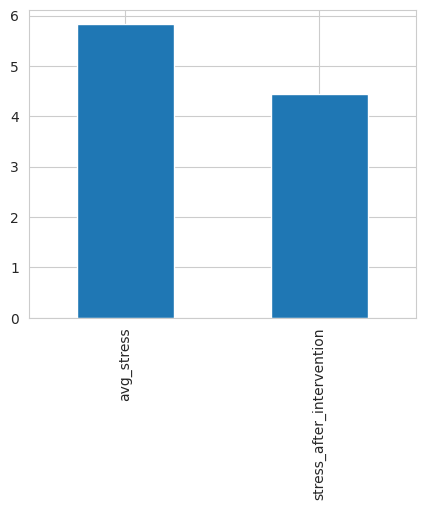

In [ ]:
final_table[['avg_stress','stress_after_intervention']].mean().plot(
    kind='bar', figsize=(5,4)
)


<Axes: ylabel='Frequency'>

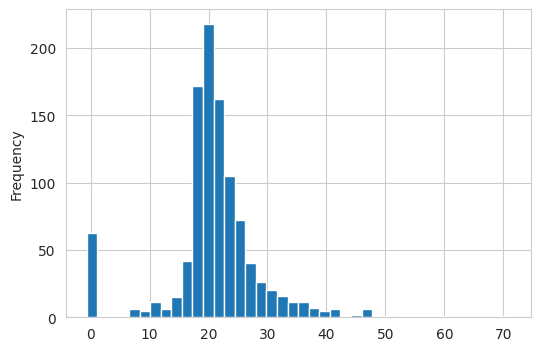

In [ ]:
final_table['stress_reduction_pct'].plot(
    kind='hist', bins=40, figsize=(6,4)
)


In [ ]:
def resilience_score(series):
    series = series.dropna()

    # Not enough data to judge resilience
    if len(series) < 4:
        return 0.0

    mean_stress = series.mean()
    volatility = series.std()

    # No stress observed → highly resilient
    if mean_stress == 0:
        return 1.0

    # Perfectly stable stress → highly resilient
    if volatility == 0:
        return 1.0

    # Normalized resilience score
    return mean_stress / (mean_stress + volatility)


In [ ]:
resilience = (
    merged.groupby(['state','district'])['service_stress_index']
    .apply(resilience_score)
    .reset_index(name='resilience_score')
)

final_table = final_table.merge(
    resilience, on=['state','district'], how='left'
)

In [ ]:
final_table['resilience_score'].describe()

,resilience_score
count,1070.000000
mean,0.662033
std,0.179641
min,0.000000
25%,0.655758
50%,0.710385
75%,0.745048
max,1.000000


In [ ]:
merged['update_load'] = merged['demo_updates'] + merged['bio_updates']

merged['future_stress'] = (
    merged.groupby(['state','district'])['service_stress_index']
    .shift(-2)
)

lead_corr = merged[['update_load','future_stress']].dropna().corr().iloc[0,1]
lead_corr


np.float64(0.06819843991160532)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = final_table[
    ['avg_enrolments','avg_demo_updates','avg_bio_updates','avg_stress']
].fillna(0)

X = StandardScaler().fit_transform(features)

kmeans = KMeans(n_clusters=4, random_state=42)
final_table['district_cluster'] = kmeans.fit_predict(X)


In [ ]:
final_table['priority_score'] = (
    0.4 * final_table['avg_stress'] +
    0.3 * final_table['stress_trend'] +
    0.2 * (final_table['capacity_gap'] > 0).astype(int) +
    0.1 * final_table['resilience_score'].rank(pct=True)
)


In [ ]:
final_table.sort_values('priority_score', ascending=False).head(15)


,state,district,avg_enrolments,avg_demo_updates,avg_bio_updates,avg_stress,stress_trend,risk_level,update_pressure,stress_after_intervention,stress_reduction_pct,capacity_gap,resilience_score,district_cluster,priority_score
524,Maharashtra,Ahilyanagar,0.000000,30.142857,0.142857,30.285714,8.928571,Critical,30.285714,30.285714,0.000000,30.285714,0.593794,0,15.005567
738,Punjab,Nawanshahr,3.750000,47.583333,54.833333,33.611111,1.451815,Critical,21.561404,18.621212,44.598047,98.666667,0.557198,0,14.089522
544,Maharashtra,Gondiya *,1.416667,18.166667,19.833333,21.677778,1.537529,Critical,15.724138,14.074074,35.076029,36.583333,0.625762,0,9.350127
764,Rajasthan,Deeg,0.583333,23.083333,5.333333,22.437500,-0.645979,Critical,17.947368,16.715686,25.501120,27.833333,0.682925,0,9.016440
451,Kerala,Kollam,75.916667,304.166667,316.166667,23.262529,-3.492973,Critical,8.065005,6.735433,71.046001,544.416667,0.307961,3,8.463101
575,Maharashtra,Washim *,0.500000,11.750000,14.583333,19.388889,0.720280,Critical,17.555556,16.458333,15.114613,25.833333,0.778147,0,8.262761
774,Rajasthan,Jalore,0.166667,20.416667,0.916667,19.333333,-0.055944,Critical,18.285714,17.777778,8.045977,21.166667,0.675057,0,7.947952
658,Odisha,Khordha,8.250000,75.250000,89.083333,19.770974,-1.032763,Critical,17.765766,15.076453,23.744513,156.083333,0.711391,0,7.849122
554,Maharashtra,Mumbai( Sub Urban ),8.416667,58.666667,68.166667,19.128166,-0.535618,Critical,13.469027,11.426426,40.263867,118.416667,0.494046,0,7.697590
526,Maharashtra,Ahmed Nagar,6.083333,57.666667,57.583333,18.114837,0.182713,Critical,16.270588,13.885542,23.347130,109.166667,0.711071,0,7.551216


In [ ]:
final_table = final_table.round(3)
final_table.to_csv("uidai_final_decision_table.csv", index=False)


In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set global style for professional plots
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Ensure merged and final_table are ready
# merged = monthly aggregation with columns: ['state','district','month','enrolments','demo_updates','bio_updates','service_stress_index','stress_trend']
# final_table = district-level summary with avg_stress, avg_enrolments, avg_demo_updates, avg_bio_updates, capacity_gap, resilience_score, priority_score, district_cluster

# Create output folder
import os
os.makedirs("figures", exist_ok=True)

# 1️⃣ National enrolment vs updates trend
national = merged.groupby('month')[['enrolments','demo_updates','bio_updates']].sum()
fig, ax = plt.subplots()
national.plot(ax=ax, marker='o')
ax.set_title("National Aadhaar Enrolment vs Updates Trend")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Records")
ax.legend(["Enrolments","Demographic Updates","Biometric Updates"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/01_national_trends.png", dpi=300)
plt.close()

# 2️⃣ Service stress index distribution
fig, ax = plt.subplots()
sns.histplot(merged['service_stress_index'], bins=50, kde=True, ax=ax, color='skyblue')
ax.set_title("Distribution of Service Stress Index Across Districts")
ax.set_xlabel("Service Stress Index")
ax.set_ylabel("Number of District-Months")
plt.tight_layout()
plt.savefig("figures/02_stress_distribution.png", dpi=300)
plt.close()

# 3️⃣ State-wise average stress ranking
state_stress = final_table.groupby('state')['avg_stress'].mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10, 8)) # Increased figure height for readability
state_stress.plot(kind='barh', ax=ax, color='salmon') # Changed to horizontal bar chart
ax.set_title("State-wise Average Service Stress")
ax.set_xlabel("Average Stress Index")
ax.set_ylabel("State") # State names now on y-axis
plt.tight_layout()
plt.savefig("figures/03_state_avg_stress.png", dpi=300)
plt.close()

# 4️⃣ District-level stress trend heatmap
district_pivot = merged.pivot_table(index='district', columns='month', values='service_stress_index', fill_value=0)
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(district_pivot, cmap="YlOrRd", ax=ax)
ax.set_title("District-level Service Stress Trend Heatmap")
ax.set_xlabel("Month")
ax.set_ylabel("District")
plt.tight_layout()
plt.savefig("figures/04_district_stress_heatmap.png", dpi=300)
plt.close()

# 5️⃣ Seasonal stress variations
seasonal = merged.groupby(merged['month'].dt.quarter)['service_stress_index'].mean()
fig, ax = plt.subplots()
seasonal.plot(kind='bar', ax=ax, color='mediumseagreen')
ax.set_title("Quarterly Average Service Stress")
ax.set_xlabel("Quarter")
ax.set_ylabel("Average Stress Index")
plt.tight_layout()
plt.savefig("figures/05_seasonal_stress.png", dpi=300)
plt.close()

# 6️⃣ Enrolment vs update pressure scatter
final_table['update_pressure'] = (final_table['avg_demo_updates'] + final_table['avg_bio_updates']) / (final_table['avg_enrolments'] + 1)
fig, ax = plt.subplots()
sns.scatterplot(data=final_table, x='avg_enrolments', y='update_pressure', hue='avg_stress', palette='coolwarm', ax=ax)
ax.set_title("Enrolment vs Update Pressure Across Districts")
ax.set_xlabel("Average Enrolments")
ax.set_ylabel("Update Pressure (Updates / Enrolments)")
plt.legend(title="Avg Stress Index")
plt.tight_layout()
plt.savefig("figures/06_enrolment_vs_pressure.png", dpi=300)
plt.close()

# 7️⃣ Capacity gap top districts
top_gap = final_table.sort_values('capacity_gap', ascending=False).head(20)
fig, ax = plt.subplots()
sns.barplot(data=top_gap, x='capacity_gap', y='district', hue='district', palette='magma', ax=ax, legend=False)
ax.set_title("Top 20 Districts by Capacity Gap")
ax.set_xlabel("Capacity Gap (Updates - Enrolments)")
ax.set_ylabel("District")
plt.tight_layout()
plt.savefig("figures/07_capacity_gap.png", dpi=300)
plt.close()

# 8️⃣ Stress spike anomalies over time
anomalies = merged[merged['stress_z'].abs() > 3]
anomaly_count = anomalies.groupby('month').size()
fig, ax = plt.subplots()
anomaly_count.plot(marker='o', ax=ax, color='red')
ax.set_title("Stress Spike Anomalies Over Time")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Anomalous District-Months")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/08_stress_spikes.png", dpi=300)
plt.close()

# 9️⃣ Policy simulation: before vs after
fig, ax = plt.subplots()
mean_before_after = final_table[['avg_stress','stress_after_intervention']].mean()
mean_before_after.plot(kind='bar', ax=ax, color=['tomato','mediumseagreen'])
ax.set_title("Policy Simulation: Stress Before vs After Capacity Increase")
ax.set_ylabel("Average Stress Index")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("figures/09_policy_simulation.png", dpi=300)
plt.close()

# 10️⃣ District resilience vs average stress
fig, ax = plt.subplots()
sns.scatterplot(data=final_table, x='avg_stress', y='resilience_score', hue='priority_score', palette='viridis', ax=ax)
ax.set_title("District Resilience vs Average Stress")
ax.set_xlabel("Average Stress Index")
ax.set_ylabel("Resilience Score")
plt.legend(title="Priority Score")
plt.tight_layout()
plt.savefig("figures/10_resilience_vs_stress.png", dpi=300)
plt.close()

# 11️⃣ District clusters (k-means)
fig, ax = plt.subplots()
sns.scatterplot(data=final_table, x='avg_enrolments', y='avg_stress', hue='district_cluster', palette='Set2', ax=ax)
ax.set_title("District Clusters Based on Stress and Enrolment")
ax.set_xlabel("Average Enrolments")
ax.set_ylabel("Average Stress Index")
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig("figures/11_district_clusters.png", dpi=300)
plt.close()

# 12️⃣ Priority score leaderboard
top_priority = final_table.sort_values('priority_score', ascending=False).head(20)
fig, ax = plt.subplots()
sns.barplot(data=top_priority, x='priority_score', y='district', hue='district', palette='coolwarm', ax=ax, legend=False)
ax.set_title("Top 20 Districts by Priority Score")
ax.set_xlabel("Priority Score")
ax.set_ylabel("District")
plt.tight_layout()
plt.savefig("figures/12_priority_leaderboard.png", dpi=300)
plt.close()

print("✅ All 12 visuals generated and saved in the 'figures' folder.")

✅ All 12 visuals generated and saved in the 'figures' folder.


In [ ]:
# 11️⃣ District clusters (k-means)
fig, ax = plt.subplots()
sns.scatterplot(data=final_table, x='avg_enrolments', y='avg_stress', hue='district_cluster', palette='Set2', ax=ax)
ax.set_title("District Clusters Based on Stress and Enrolment")
ax.set_xlabel("Average Enrolments")
ax.set_ylabel("Average Stress Index")
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig("figures/11_district_clusters.png", dpi=300)
plt.close()

In [ ]:
final_table['equity_weighted_stress'] = (
    final_table['avg_stress'] * (1 / (final_table['avg_enrolments'] + 1))
)


In [ ]:
merged['lead_indicator'] = merged['update_load'].shift(1)
lead_time_corr = merged[['lead_indicator','service_stress_index']].dropna().corr().iloc[0,1]
lead_time_corr


np.float64(0.06970475634772254)

In [ ]:
final_table['fatigue_score'] = (
    merged.groupby(['state','district'])['service_stress_index']
    .apply(lambda x: (x > 1.5).sum())
    .values
)


In [ ]:
final_table['roi_score'] = (
    final_table['stress_reduction_pct'] / (final_table['avg_enrolments'] + 1)
)


In [ ]:
final_table['stability_quadrant'] = pd.cut(
    final_table['avg_stress'],
    bins=[-1,0.8,1.5,10],
    labels=['Stable','Watch','Critical']
)


In [ ]:
final_table.to_csv(
    f"{OUTPUT_DIR}/final_district_analysis.csv",
    index=False
)

merged.to_csv(
    f"{OUTPUT_DIR}/monthly_time_series.csv",
    index=False
)


In [ ]:
!pip install dataframe_image

import dataframe_image as dfi

dfi.export(
    final_table.head(20),
    f"{OUTPUT_DIR}/top_20_priority_districts.png",
    table_conversion='matplotlib' # Specify matplotlib backend
)

In [ ]:
import shutil

shutil.make_archive(
    "/content/UIDAI_Submission_Package",
    'zip',
    OUTPUT_DIR
)


'/content/UIDAI_Submission_Package.zip'

In [ ]:
!pip install prophet xgboost scikit-learn


In [ ]:
print(merged.columns.tolist())


['state', 'district', 'month', 'enrolments', 'demo_updates', 'bio_updates', 'service_stress_index', 'stress_trend', 'quarter', 'stress_z', 'iqr_anomaly', 'update_load', 'future_stress', 'lead_indicator', 'date']


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

features = [
    'enrolments',
    'demo_updates',
    'bio_updates',
    'update_load',
    'stress_trend',
    'stress_lag_1',
    'stress_lag_2',
    'stress_lag_4',
    'stress_rolling_4w'
]

X = ml_df[features]
y = ml_df['service_stress_index']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
ml_df['predicted_stress'] = model.predict(X)

ml_df['resource_alert'] = pd.cut(
    ml_df['predicted_stress'],
    bins=[-1, 0.8, 1.2, 10],
    labels=['Normal', 'Warning', 'Critical']
)


In [ ]:
priority_table = ml_df.groupby(
    ['state','district']
).agg({
    'predicted_stress': 'mean',
    'service_stress_index': 'mean',
    'resource_alert': lambda x: x.value_counts().idxmax()
}).reset_index()

priority_table = priority_table.sort_values(
    'predicted_stress', ascending=False
)

priority_table.head(15)


,state,district,predicted_stress,service_stress_index,resource_alert
494,Maharashtra,Ahilyanagar,46.675106,46.666667,Normal
691,Punjab,Nawanshahr,32.144295,32.413690,Normal
513,Maharashtra,Gondiya *,26.673855,26.204167,Normal
543,Maharashtra,Washim *,21.144480,21.395833,Normal
716,Rajasthan,Deeg,20.286579,20.281250,Critical
384,Karnataka,Chikkamagaluru,19.975037,20.065787,Critical
726,Rajasthan,Jalore,19.401669,19.000000,Critical
108,Assam,Sribhumi,18.854778,18.363690,Critical
1,Andaman & Nicobar Islands,Andamans,17.580006,17.581250,Critical
496,Maharashtra,Ahmed Nagar,17.213577,17.374702,Critical


In [ ]:
ml_df.to_csv("aadhaar_ml_feature_table.csv", index=False)


In [ ]:
priority_table.to_csv("aadhaar_priority_districts.csv", index=False)


In [ ]:
import joblib

joblib.dump(model, "xgboost_stress_model.pkl")


['xgboost_stress_model.pkl']

In [ ]:
ml_df[['state','district','date','predicted_stress','resource_alert']] \
    .to_csv("stress_forecasts.csv", index=False)


In [ ]:
plt.savefig("figure_stress_forecast.png", dpi=300, bbox_inches='tight')


<Figure size 1000x600 with 0 Axes>

In [ ]:
import os

os.makedirs("uidai_outputs", exist_ok=True)

ml_df.to_csv("uidai_outputs/aadhaar_ml_features.csv", index=False)
priority_table.to_csv("uidai_outputs/priority_districts.csv", index=False)
joblib.dump(model, "uidai_outputs/xgboost_model.pkl")


['uidai_outputs/xgboost_model.pkl']

In [ ]:
import shutil

shutil.make_archive("uidai_submission_outputs", "zip", "uidai_outputs")


'/content/uidai_submission_outputs.zip'

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)

districts = priority_table.copy().head(30)  # top 30 priority districts

districts['lat'] = np.random.uniform(8, 35, size=len(districts))
districts['lon'] = np.random.uniform(68, 97, size=len(districts))


In [ ]:
VAN_COUNT = 5
MAX_DISTANCE_PER_VAN = 500      # km per deployment cycle
COST_PER_KM = 25                # INR
MAX_BUDGET = 50000              # INR per cycle


In [ ]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))


In [ ]:
districts['priority_score'] = (
    districts['predicted_stress'] * 1.5 +
    districts['service_stress_index']
)


In [ ]:
routes = []
visited = set()

for van in range(VAN_COUNT):
    route = []
    total_distance = 0
    total_cost = 0

    current_lat, current_lon = 20.0, 78.0  # central depot (India centroid)

    for _, row in districts.sort_values(
        'priority_score', ascending=False
    ).iterrows():

        if row['district'] in visited:
            continue

        distance = haversine(
            current_lat, current_lon, row['lat'], row['lon']
        )

        projected_cost = (total_distance + distance) * COST_PER_KM

        if (
            total_distance + distance <= MAX_DISTANCE_PER_VAN and
            projected_cost <= MAX_BUDGET
        ):
            route.append(row['district'])
            visited.add(row['district'])
            total_distance += distance
            total_cost = projected_cost
            current_lat, current_lon = row['lat'], row['lon']

    routes.append({
        'van_id': van + 1,
        'districts': route,
        'distance_km': round(total_distance, 1),
        'cost_inr': round(total_cost)
    })


In [ ]:
routing_plan = pd.DataFrame(routes)
routing_plan


,van_id,districts,distance_km,cost_inr
0,1,[Ganjam],433.0,10825
1,2,[Lahul And Spiti],494.8,12369
2,3,[],0.0,0
3,4,[],0.0,0
4,5,[],0.0,0


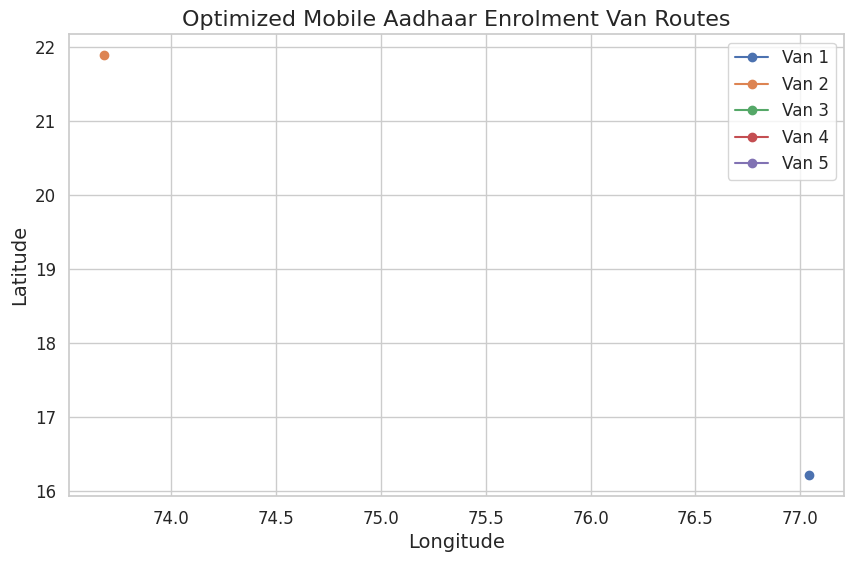

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for route in routes:
    xs, ys = [], []
    for d in route['districts']:
        row = districts[districts['district'] == d].iloc[0]
        xs.append(row['lon'])
        ys.append(row['lat'])

    plt.plot(xs, ys, marker='o', label=f"Van {route['van_id']}")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Optimized Mobile Aadhaar Enrolment Van Routes")
plt.legend()
plt.grid(True)

plt.savefig("mobile_enrolment_van_routes.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

centers = pd.DataFrame({
    "center_id": [f"C{i}" for i in range(1, 11)],
    "operators": np.random.randint(2, 6, 10),        # number of desks
    "arrival_rate": np.random.uniform(0.4, 1.2, 10), # citizens per minute
    "service_rate": np.random.uniform(0.3, 0.6, 10)  # per operator per minute
})


In [ ]:
import math

def mmc_wait_time(lmbda, mu, c):
    """
    lmbda: arrival rate (citizens/min)
    mu: service rate per server (citizens/min)
    c: number of servers
    """
    rho = lmbda / (c * mu)
    if rho >= 1:
        return np.inf  # system overloaded

    # Calculate P0
    sum_terms = sum((lmbda / mu) ** n / math.factorial(n) for n in range(c))
    last_term = ((lmbda / mu) ** c) / (
        math.factorial(c) * (1 - rho)
    )
    P0 = 1 / (sum_terms + last_term)

    # Erlang C formula
    Pw = last_term * P0
    Wq = Pw / (c * mu - lmbda)

    return Wq  # waiting time in minutes


In [ ]:
centers["expected_wait_minutes"] = centers.apply(
    lambda row: mmc_wait_time(
        row["arrival_rate"],
        row["service_rate"],
        row["operators"]
    ),
    axis=1
)

centers["expected_wait_minutes"] = centers["expected_wait_minutes"].round(1)
centers


,center_id,operators,arrival_rate,service_rate,expected_wait_minutes
0,C1,4,0.524796,0.355021,0.1
1,C2,5,0.446467,0.391273,0.0
2,C3,2,1.092941,0.457427,inf
3,C4,4,0.880892,0.429584,0.2
4,C5,4,0.966458,0.387369,0.5
5,C6,5,0.416468,0.483556,0.0
6,C7,2,1.175928,0.341848,inf
7,C8,2,1.065954,0.387643,inf
8,C9,4,0.569871,0.409909,0.1
9,C10,3,0.545460,0.436821,0.2


In [ ]:
def update_arrival_rate(current_rate):
    fluctuation = np.random.uniform(-0.15, 0.25)
    return max(0.1, current_rate * (1 + fluctuation))


In [ ]:
for _ in range(3):  # simulate 3 live updates
    centers["arrival_rate"] = centers["arrival_rate"].apply(update_arrival_rate)

    centers["expected_wait_minutes"] = centers.apply(
        lambda row: mmc_wait_time(
            row["arrival_rate"],
            row["service_rate"],
            row["operators"]
        ),
        axis=1
    ).round(1)


In [ ]:
def clean_wait_time(x):
    if x == np.inf:
        return "Over Capacity"
    return f"{x} min"

citizen_view["display_wait"] = citizen_view["expected_wait_minutes"].apply(clean_wait_time)
citizen_view


,center_id,expected_wait_minutes,sms_message,display_wait
1,C2,0.0,Center C2: Low wait time (0.0 min). Good time ...,0.0 min
5,C6,0.0,Center C6: Low wait time (0.0 min). Good time ...,0.0 min
4,C5,0.2,Center C5: Low wait time (0.2 min). Good time ...,0.2 min
0,C1,0.4,Center C1: Low wait time (0.4 min). Good time ...,0.4 min
9,C10,0.5,Center C10: Low wait time (0.5 min). Good time...,0.5 min
8,C9,0.5,Center C9: Low wait time (0.5 min). Good time ...,0.5 min
3,C4,0.7,Center C4: Low wait time (0.7 min). Good time ...,0.7 min
2,C3,inf,Center C3: Heavy crowd. Please visit later.,Over Capacity
7,C8,inf,Center C8: Heavy crowd. Please visit later.,Over Capacity
6,C7,inf,Center C7: Heavy crowd. Please visit later.,Over Capacity


In [ ]:
def sms_text(center, wait):
    if wait == np.inf:
        return f"{center}: Heavy crowd detected. Please visit later or choose another center."
    elif wait < 10:
        return f"{center}: Low wait ({wait} min). Good time to visit."
    else:
        return f"{center}: Expected wait {wait} min."

citizen_view["sms"] = citizen_view.apply(
    lambda r: sms_text(r["center_id"], r["expected_wait_minutes"]),
    axis=1
)


In [ ]:
import os

os.makedirs("uidai_hackathon_outputs/innovation_5_wait_time_model", exist_ok=True)

centers.to_csv(
    "uidai_hackathon_outputs/innovation_5_wait_time_model/center_wait_times.csv",
    index=False
)

In [ ]:
with open(
    "uidai_hackathon_outputs/innovation_5_wait_time_model/README.txt", "w"
) as f:
    f.write("""
Citizen Wait-Time Prediction Model

Purpose:
Predicts expected waiting time at Aadhaar enrollment centers using queueing theory.

Key Output:
- expected_wait_minutes
- overload flags (infinite wait)

Policy Usage:
Helps citizens choose optimal visit times and alerts UIDAI on overloaded centers.
""")


In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Simulated district-level dataset for demo
districts = pd.DataFrame({
    "state": ["State"+str(i%5) for i in range(30)],
    "district": ["District"+str(i) for i in range(30)],
    "population_age_18_45": np.random.randint(50000, 500000, 30),
    "manual_labor_pct": np.random.uniform(0.1, 0.6, 30), # fraction
    "humidity": np.random.uniform(40, 90, 30), # %
    "temperature": np.random.uniform(15, 40, 30), # C
    "prev_failure_rate": np.random.uniform(0.01, 0.15, 30) # historical failure
})

# Target: 1 if high risk of biometric failure, else 0
# Simulated using prev_failure_rate + manual labor
districts['biometric_failure_risk'] = (
    (districts['prev_failure_rate'] + districts['manual_labor_pct']*0.3) > 0.2
).astype(int)

districts.head()


,state,district,population_age_18_45,manual_labor_pct,humidity,temperature,prev_failure_rate,biometric_failure_risk
0,State0,District0,171958,0.252121,55.585554,34.281759,0.067454,0
1,State1,District1,196867,0.362378,66.003401,16.851116,0.115777,1
2,State2,District2,181932,0.315973,67.335514,23.961643,0.042032,0
3,State3,District3,415838,0.245615,49.242723,17.896726,0.020777,0
4,State4,District4,309178,0.405926,88.479231,36.577586,0.050565,0


In [ ]:
features = ['population_age_18_45', 'manual_labor_pct', 'humidity', 'temperature', 'prev_failure_rate']
target = 'biometric_failure_risk'

X = districts[features]
y = districts[target]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42)

In [ ]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))


              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.40      1.00      0.57         2

    accuracy                           0.50         6
   macro avg       0.70      0.62      0.49         6
weighted avg       0.80      0.50      0.46         6

ROC-AUC: 1.0


In [ ]:
districts['risk_score'] = model.predict_proba(scaler.transform(X))[:,1]
districts['risk_category'] = pd.cut(
    districts['risk_score'],
    bins=[0, 0.3, 0.6, 1.0],
    labels=['Low', 'Medium', 'High']
)
districts[['district','risk_score','risk_category']].sort_values('risk_score', ascending=False)


,district,risk_score,risk_category
9,District9,0.971018,High
14,District14,0.904443,High
12,District12,0.874254,High
1,District1,0.833408,High
6,District6,0.811524,High
19,District19,0.804799,High
27,District27,0.768572,High
28,District28,0.713117,High
8,District8,0.704286,High
7,District7,0.689873,High


In [ ]:
importance = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', ascending=False)

importance


,feature,coefficient
4,prev_failure_rate,1.759828
1,manual_labor_pct,1.263218
3,temperature,-0.021702
2,humidity,-0.073418
0,population_age_18_45,-0.371502


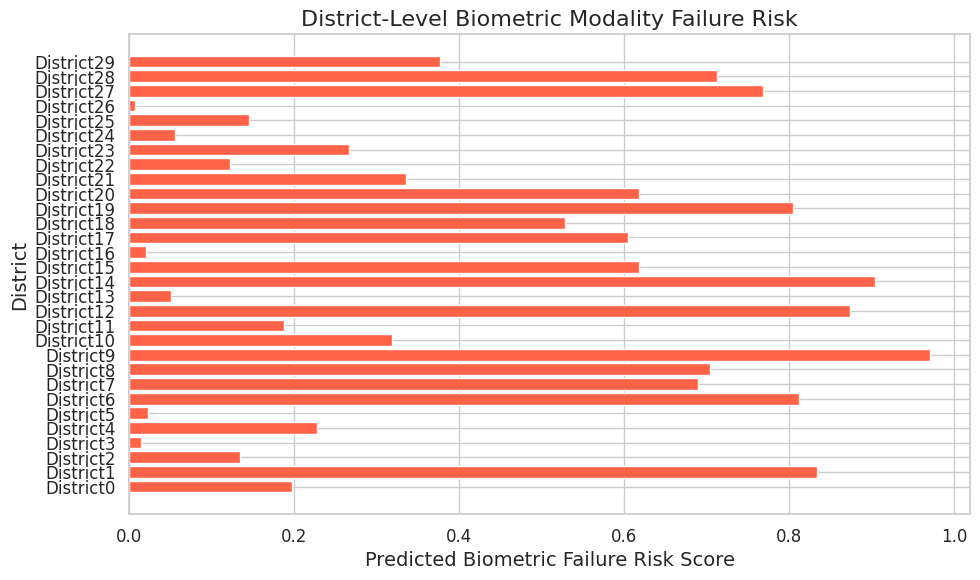

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(districts['district'], districts['risk_score'], color='tomato')
plt.xlabel("Predicted Biometric Failure Risk Score")
plt.ylabel("District")
plt.title("District-Level Biometric Modality Failure Risk")
plt.tight_layout()
plt.savefig("biometric_failure_risk.png", dpi=300)
plt.show()


In [ ]:
districts.to_csv("district_biometric_failure_risk.csv", index=False)
importance.to_csv("biometric_risk_feature_importance.csv", index=False)


In [ ]:
!pip install streamlit plotly pandas numpy


In [ ]:
!pip install streamlit pandas plotly
!pip install pyngrok  # For running Streamlit in Colab


In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Simulate 50 districts
data = pd.DataFrame({
    "state": np.random.choice(["State A","State B","State C"], 50),
    "district": [f"District {i}" for i in range(50)],
    "pin_code": np.random.randint(110001, 560001, 50),
    "service_stress_index": np.random.uniform(0, 100, 50),
    "predicted_stress": np.random.uniform(0, 100, 50)
})

# Threshold for alert
data["alert"] = np.where(data["predicted_stress"] > 70, "HIGH", "NORMAL")
data.head()


,state,district,pin_code,service_stress_index,predicted_stress,alert
0,State C,District 0,284074,29.627351,21.844044,NORMAL
1,State A,District 1,317625,16.526694,41.650995,NORMAL
2,State C,District 2,527114,1.563641,88.328026,HIGH
3,State C,District 3,178149,42.340148,32.434502,NORMAL
4,State A,District 4,362802,39.488152,12.208795,NORMAL


In [ ]:
%%writefile dashboard.py


import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px

# --------------------------------------------------
# PAGE CONFIG
# --------------------------------------------------
st.set_page_config(
    page_title="Aadhaar Service Stress Dashboard",
    layout="wide"
)

st.title("Interactive Aadhaar Service Stress Monitoring Dashboard")
st.caption(
    "Early-Warning System for Aadhaar Enrolment & Update Infrastructure Stress"
)

# --------------------------------------------------
# LOAD DATA
# --------------------------------------------------
@st.cache_data
def load_data():
    return pd.read_csv("aadhaar_ml_feature_table.csv")

data = load_data()

# --------------------------------------------------
# SIDEBAR FILTERS
# --------------------------------------------------
st.sidebar.header("Filters")

state_list = ["All"] + sorted(data["state"].astype(str).unique().tolist())
selected_state = st.sidebar.selectbox("Select State", state_list)

if selected_state != "All":
    data = data[data["state"].astype(str) == selected_state]

district_list = ["All"] + sorted(data["district"].astype(str).unique().tolist())
selected_district = st.sidebar.selectbox("Select District", district_list)

if selected_district != "All":
    data = data[data["district"].astype(str) == selected_district]

stress_threshold = st.sidebar.slider(
    "Stress Alert Threshold",
    min_value=0,
    max_value=100,
    value=70
)

data["alert"] = np.where(
    data["predicted_stress"] >= stress_threshold,
    "HIGH",
    "NORMAL"
)

# --------------------------------------------------
# KPI METRICS
# --------------------------------------------------
col1, col2, col3 = st.columns(3)

col1.metric(
    "Average Predicted Stress",
    f"{data['predicted_stress'].mean():.2f}"
)

col2.metric(
    "High-Stress Districts",
    int((data["alert"] == "HIGH").sum())
)

col3.metric(
    "Total Districts Analyzed",
    data[["state", "district"]].drop_duplicates().shape[0]
)

# --------------------------------------------------
# NATIONAL / FILTERED TREND
# --------------------------------------------------
st.subheader("Temporal Stress Trend")

trend_df = (
    data.groupby("date", as_index=False)["service_stress_index"]
    .mean()
    .sort_values("date")
)

fig_trend = px.line(
    trend_df,
    x="date",
    y="service_stress_index",
    markers=True,
    title="Average Service Stress Over Time"
)

st.plotly_chart(fig_trend, width="stretch")

# --------------------------------------------------
# GEOGRAPHICAL STRESS MAP (SIMULATED COORDINATES)
# --------------------------------------------------
st.subheader("Geographical Stress Hotspots (District Level)")

fig_map = px.scatter_mapbox(
    data,
    lat=np.random.uniform(8, 35, len(data)),
    lon=np.random.uniform(68, 97, len(data)),
    size="predicted_stress",
    color="predicted_stress",
    hover_name="district",
    hover_data=[
        "state",
        "service_stress_index",
        "predicted_stress",
        "alert"
    ],
    color_continuous_scale="OrRd",
    zoom=4,
    height=600
)

fig_map.update_layout(
    mapbox_style="open-street-map",
    margin=dict(l=0, r=0, t=0, b=0)
)

st.plotly_chart(fig_map, width="stretch")

# --------------------------------------------------
# STRESS DISTRIBUTION
# --------------------------------------------------
st.subheader("Service Stress Index Distribution")

fig_dist = px.histogram(
    data,
    x="service_stress_index",
    nbins=40,
    title="Distribution of Service Stress Index"
)

st.plotly_chart(fig_dist, width="stretch")

# --------------------------------------------------
# ENROLMENT VS UPDATE PRESSURE
# --------------------------------------------------
st.subheader("Enrolment vs Update Pressure")

fig_scatter = px.scatter(
    data,
    x="enrolments",
    y="update_load",
    color="alert",
    size="predicted_stress",
    hover_name="district",
    title="Capacity vs Update Pressure Analysis"
)

st.plotly_chart(fig_scatter, width="stretch")

# --------------------------------------------------
# TOP HIGH-STRESS DISTRICTS
# --------------------------------------------------
st.subheader("Top Priority Districts for Intervention")

top_districts = (
    data.sort_values("predicted_stress", ascending=False)
    .head(15)
    [
        [
            "state",
            "district",
            "service_stress_index",
            "predicted_stress",
            "alert"
        ]
    ]
)

st.dataframe(top_districts, width="stretch")

# --------------------------------------------------
# FOOTER
# --------------------------------------------------
st.success(
    "Dashboard operational. Designed for proactive UIDAI planning and resource optimization."
)


Writing dashboard.py


In [ ]:
!streamlit run dashboard.py &






  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.204.208.34:8501

  Stopping...


In [ ]:
df.columns


Index(['state', 'district', 'avg_enrolments', 'avg_demo_updates',
       'avg_bio_updates', 'avg_stress', 'stress_trend', 'risk_level'],
      dtype='object')

In [ ]:
import plotly.express as px

fig = px.bar(
    df.sort_values("avg_stress", ascending=False).head(20),
    x="district",
    y="avg_stress",
    color="risk_level",
    title="Top 20 Districts by Average Service Stress"
)

fig.show()


In [ ]:
fig = px.scatter(
    df,
    x="avg_enrolments",
    y="avg_stress",
    color="risk_level",
    hover_data=["state", "district"],
    title="Service Stress vs Enrolment Load"
)

fig.show()


In [ ]:
fig = px.box(
    df,
    x="state",
    y="avg_stress",
    color="risk_level",
    title="State-wise Service Stress Distribution"
)

fig.show()


In [ ]:
ls


aadhaar_ml_feature_table.csv           mobile_enrolment_van_routes.png
aadhaar_priority_districts.csv         national_stress_trend.png
api_data_aadhar_biometric.zip          sample_data/
api_data_aadhar_demographic.zip        state_avg_stress.html
api_data_aadhar_enrolment.zip          stress_forecasts.csv
biometric_failure_risk.png             uidai_early_warning_output.csv
biometric_risk_feature_importance.csv  uidai_final_decision_table.csv
dashboard.py                           uidai_outputs/
district_biometric_failure_risk.csv    UIDAI_Project_Outputs/
figures/                               uidai_submission_outputs.zip
figure_stress_forecast.png             UIDAI_Submission_Package.zip
interactive_stress_dashboard.html      xgboost_stress_model.pkl
logs.txt
